In [9]:
import torch
if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available")

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

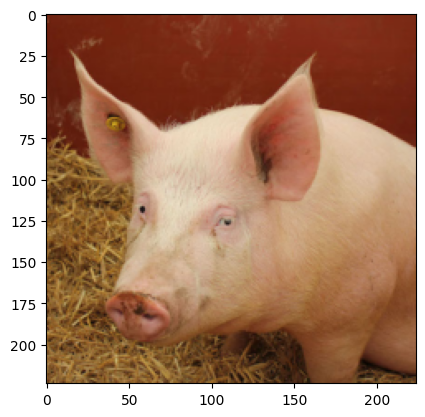

In [20]:
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
    transforms.Resize(224), # 224x224 is the common size for Google ImageNet
    transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None, :, :, :]
plt.imshow(pig_tensor[0].numpy().transpose(1, 2, 0))

#### - `ToTensor`
`torchvision.transforms.ToTensor()` is a function in the PyTorch library that converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]. 

#### - `[None, :, :, :]`
The `None` is used to add an extra dimension to the start of the tensor, creating a batch of a single image. 
> "all inputs to modules should be of the form batch_size x num_channels x height x width"

#### - PyTorch Tensor vs. Numpy Array
PyTorch tensors and numpy arrays are both multi-dimensional arrays, but they have some key differences:

1. **Device Compatibility**: PyTorch tensors can be moved to GPU for faster computations, while numpy arrays only operate on CPU.

2. **Automatic Differentiation**: PyTorch tensors support automatic differentiation and gradient computation, which are essential for training neural networks. Numpy does not have this feature.

3. **Tensor Operations**: PyTorch provides a wide range of operations specifically designed for tensor computations, many of which are not available in numpy.

4. **Data Types**: Both PyTorch tensors and numpy arrays support various data types, but the naming conventions are different. For example, a 64-bit integer is `torch.int64` in PyTorch and `numpy.int64` in numpy.

5. **Memory Sharing**: PyTorch tensors can share the same memory under certain conditions for efficient computing, while numpy arrays cannot.

6. **Interoperability**: PyTorch tensors can be easily converted to numpy arrays and vice versa, but note that PyTorch tensors on GPU need to be moved to CPU before converting to numpy arrays.

In the context of the provided code, the PyTorch tensor is converted to a numpy array for visualization with matplotlib, which operates on numpy arrays.

In [41]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights # pretrained 50-layer ResNet


In [42]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
        
    def forward(self, x):
        return (x - self.mean.type_as(x)[None, :, None, None]) / self.std.type_as(x)[None, :, None, None]
    
# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.eval();
pred = model(norm(pig_tensor))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/skylu/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100.0%


#### - `[None, :, None, None]` Reshape
The effect of `[None, :, None, None]` is to reshape the mean and standard deviation tensors from a shape of `[num_cannels]`, in this case `[3]`, to a shape of `[1, num_channels, 1, 1]`. This matches the shape of the input tensor `x`, which is expected to have a shape of `[batch_size, num_channels, height, width]`. This allows for the subtraction and division operations to be performed correctly.
#### - Normalization
Normalization by subtracting the mean and dividing by the standard deviation is a common technique in statistics known as standardization or Z-score normalization.

The purpose of this technique is to transform the data to have zero mean and unit variance. Here's why:

1. **Zero Mean**: By subtracting the mean of the data, we ensure that the data is centered around zero. This can help remove any bias in the data due to the mean. For example, if we're dealing with images, different lighting conditions could result in different means. By centering the data, we remove this effect.

2. **Unit Variance**: By dividing by the standard deviation, we scale the data so that it has a standard deviation of 1. This ensures that all features have the same scale. This is important in machine learning because many algorithms are sensitive to the scale of the features. For example, in gradient descent, features with larger scales can dominate the updates to the model parameters.

In the context of the provided code, the normalization is performed on the input images before they are passed to the model. The mean and standard deviation values used are standard values for ImageNet images. By using these values, the normalization ensures that the model receives input data in the same format as the data it was originally trained on.
#### - `eval()`
The `.eval()` method in PyTorch is used to set the model to evaluation mode. This has any effect only on certain modules. For example, Dropout layers will not drop activations and BatchNorm layers will use running estimates instead of batch statistics. 

This is important because these behaviors are desirable during training, but not during testing and model evaluation. During testing, we want the model to use its learned parameters as is, without any randomness or additional computation introduced by these layers.

#### - `weights=ResNet50_Weights.DEFAULT`
`pretrained=true` might be depracated in future versions. Instead, we can import and load weights using
```python
from torchvision.models import resnet50, ResNet50_Weights
resnet50(weights=ResNet50_Weights.DEFAULT)
```

In [43]:
import json

with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

hog
